In [1]:
import numpy as np
import random
from tqdm.notebook import tqdm
import copy
from scipy.stats import bernoulli
from scipy.special import softmax
import matplotlib.pyplot as plt
import scipy

In [2]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0

In [3]:
def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP code by Ian Osband.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim





In [4]:
class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState

    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0

    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd

    def get_state(self):
        '''
        Converts state coordinates to a scalar value
        '''
        return self.state

    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [5]:
class Deep_Sea(Environment):
    '''
    Description:
        A deep sea environment, where a diver goes
        down and each time and she needs to make a
        decision to go left or right.
        environment terminates after fixed time step

    Observation:
        [horizontal position, vertical position]

    Actions:
        2 possible actions:
        0 - left
        1 - right

    Starting State:
        start at position 0, time step 0

    Episode termination:
        Env terminates after fixed number of time steps
    '''

    def __init__(self, num_steps):
        '''
        Inputs:
            num_steps: An integer that represents the size of the DeepSea environment
        '''
        self.num_steps = num_steps
        self.epLen = num_steps
        self.flip_mask = 2*np.random.binomial(1,0.5,(num_steps,num_steps))-1
        self.nAction = 2
        self.nState = pow(num_steps,2)
        self.epLen = num_steps
        self.R = {}
        self.states = {}
        for s in range(self.num_steps):
            for s_ in range(self.num_steps):
                self.R[(s,s_), 0] = (0, 0)
                self.R[(s,s_), 1] = (-0.01/self.nState, 0)
                self.states[(s,s_)] = 0
        self.R[(self.num_steps-2,self.num_steps-2),1] = (1,0) #-1 added 

    def name(self):
        return  "deep sea"

    def reset(self):
        self.state = (0,0)
        self.timestep = 0
        return copy.deepcopy(self.state)

    def get_state(self):
        '''
        Converts state coordinates to a scalar value
        '''
        return self.state[1]*self.num_steps+self.state[0] 

    def advance(self,action):
        assert action in [0,1], "invalid action"
        self.state_prev = self.state
        step_horizontal = (2*action-1)
        horizontal = max(self.state[0] + step_horizontal, 0)
        vertical = self.state[1] + 1

        done =  bool(vertical == self.num_steps-1) #-1 added 

        self.state = (horizontal, vertical)
        self.timestep += 1

        r = self.R[self.state_prev,action][0]

        return r, self.get_state(), done

    def argmax(self,b):
        return np.random.choice(np.where(b == b.max())[0])
    

In [6]:
class Beyond_UCB(object):
    '''
    Earlier impementation of Q-learning with BeyondGreedy, included for archival purposes
    '''
    def __init__(self,env,K,gamma):
        self.env = env
        self.K = K
        self.gamma = gamma
        self.mu = self.env.nAction
        #Step 2: Initializes
        self.Q = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) #+ self.env.epLen
        self.N = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        self.p = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) + 1/self.env.nAction
        self.V = np.zeros((self.env.epLen+1,self.env.nState)) #+ self.env.epLen
        self.V[self.env.epLen,:] = 0.0
    
    def act(self,s,h):
        '''
        Implements step 6
        Inputs:
        s - the current state
        h - the current step
        Returns:
        a - the action under the current policy at state s at step h
        '''
        return np.random.choice(self.env.nAction,p=self.p[h,s,:])
    
    def update(self,s,a,r,s_,h,k):
        
        self.N[h,s,a] += 1
        alpha = (self.env.epLen+1)/(self.env.epLen + self.N[h,s,a])
        self.Q[h,s,a] = (1-alpha)*self.Q[h,s,a] + alpha * (r + self.V[h+1,s_])
        self.V[h,s] = np.dot(self.p[h,s,:],self.Q[h,s,:])
    
    def update_p(self):
        for h in range(self.env.epLen):
            for s in range(self.env.nState):
                sums = 0.0
                b = self.env.argmax(self.Q[h,s,:])
                for a in range(self.env.nAction):
                    #print(self.Q[h,s,b]-self.Q[h,s,a])
                    if a != b:
                        self.p[h,s,a] = 1/(self.mu + self.gamma*(self.Q[h,s,b]-self.Q[h,s,a]))
                        sums += self.p[h,s,a]
                    #print(self.Q[h,s,b]-self.Q[h,s,a])
                    #print(self.p[h,s,a])
                self.p[h,s,b] = 1 - sums
    
    def run(self):
        R = 0
        Rvec = []
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update(s,a,r,s_,h,k)
                R += r
            Rvec.append(R)
            self.update_p()
        return Rvec
        
        

In [7]:
class Eps_Q(object):
    def __init__(self,env,K,eps):
        self.env = env
        self.K = K
        self.eps = eps
        self.mu = self.env.nAction
        self.Q = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) #+ self.env.epLen
        self.N = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        self.V = np.zeros((self.env.epLen+1,self.env.nState)) #+ self.env.epLen
        self.V[self.env.epLen,:] = 0.0
    
    def act(self,s,h):
        c = np.random.uniform()
        if c < self.eps:
            return np.random.choice(self.env.nAction)
        else:
            return self.env.argmax(self.Q[h,s,:])
    
    def update(self,s,a,r,s_,h,k):
        self.N[h,s,a] += 1
        alpha = (self.env.epLen+1)/(self.env.epLen + self.N[h,s,a])
        self.Q[h,s,a] = (1-alpha)*self.Q[h,s,a] + alpha * (r + self.V[h+1,s_])
        self.V[h,s] = (1-self.eps)*max(self.Q[h,s,:]) + self.eps*min(self.Q[h,s,:]) # NOTE: WHY?
    
    def run(self):
        R = 0
        Rvec = []
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = env.get_state()
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update(s,a,r,s_,h,k)
                R += r
            Rvec.append(R)
        return Rvec
        

In [8]:
class Softmax_Q(object):
    '''

    '''
    def __init__(self,env,K,eta):
        self.env = env
        self.K = K
        self.eta = eta # temperate parameter
        self.mu = self.env.nAction
        self.Q = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) #+ self.env.epLen
        self.N = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        self.V = np.zeros((self.env.epLen+1,self.env.nState)) #+ self.env.epLen
        self.V[self.env.epLen,:] = 0.0
    
    def act(self,s,h):
        p_a = softmax(self.eta*self.Q[h,s,:]) # probability of choosing each action
        return np.random.choice(self.env.nAction, p=p_a)

    def update(self,s,a,r,s_,h,k):
        self.N[h,s,a] += 1
        alpha = (self.env.epLen+1)/(self.env.epLen + self.N[h,s,a])
        self.Q[h,s,a] = (1-alpha)*self.Q[h,s,a] + alpha * (r + self.V[h+1,s_])

        p_a = softmax(self.eta*self.Q[h,s,:])
        self.V[h,s] =  np.dot(p_a , self.Q[h,s,:])
    
    def run(self):
        R = 0
        Rvec = []
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = env.get_state()
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)
                self.update(s,a,r,s_,h,k)
                R += r
            Rvec.append(R)
        return Rvec

In [9]:
class Beyond_Q(object):
    '''
    Implements Q-learning with BeyondGreedy Exploration
    Inputs:
    env - the environment the agent with be interacting with
    K - the number of episodes
    gamma - exploration parameter
    Returns:
    Rvec - a vector with the cumulative returns for each episode k \in [K]
    '''
    def __init__(self,env,K,gamma):
        
        self.env = env
        self.K = K
        self.gamma = gamma
        self.mu = self.env.nAction
        #Step 2: Initializes Q, N, p, V.
        self.Q = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) #+ self.env.epLen
        self.N = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        self.p = np.zeros((self.env.epLen,self.env.nState,self.env.nAction)) + 1/self.env.nAction
        self.V = np.zeros((self.env.epLen+1,self.env.nState)) #+ self.env.epLen
        self.V[self.env.epLen,:] = 0.0
    
    def act(self,s,h):
        '''
        Implements step 6
        Inputs:
        s - the current state
        h - the current step
        Returns:
        a - the action under the current policy at state s at step h
        '''
        return np.random.choice(self.env.nAction, p=self.p[h,s,:])
    
    def update(self,s,a,r,s_,h,k):
        '''
        Implements steps 7-10
        Inputs:
        s - the current state
        a - the current action
        r - the observed reward
        s_ - the observed next state
        h - the current step in the episode
        k - the current episode
        '''
        #Step 7
        self.N[h,s,a] += 1
        #Step 8
        alpha = (self.env.epLen+1) / (self.env.epLen + self.N[h,s,a])

        self.Q[h,s,a] = (1-alpha)*self.Q[h,s,a] + alpha * (r + self.V[h+1,s_])
        #Step 9
        sums = 0.0
        b = self.env.argmax(self.Q[h,s,:])
        for a_ in range(self.env.nAction):
            if a_ != b:
                self.p[h,s,a_] = 1/(self.mu + self.gamma*(self.Q[h,s,b]-self.Q[h,s,a_]))
                sums += self.p[h,s,a_]
        self.p[h,s,b] = 1 - sums
        #Step 10
        self.V[h,s] = np.dot(self.p[h,s,:],self.Q[h,s,:])
    
    def run(self):
        '''
        A function for handling the agents interaction with the environment
        returns:
        Rvec - a vector with the cumulative rewards
        '''
        R = 0
        Rvec = []
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while not done:
                s = self.env.get_state()
                h = self.env.timestep
                a = self.act(s,h)
                r,s_,done = self.env.advance(a)

                self.update(s,a,r,s_,h,k)
                R += r
            Rvec.append(R)
        return Rvec
        
        

In [10]:
K = 10000
runs = 10
delta = 1/K
eta = 0.1
epsilon = 0.1

env = make_riverSwim(epLen = 20,nState = 6)
gamma = np.sqrt(K*env.epLen*env.nAction/(env.nAction*env.nState*env.epLen*np.log(2/delta)))
r1 = np.zeros((runs,K)) # Beyond_Q
r2 = np.zeros((runs,K)) # E-Greedy
r3 = np.zeros((runs,K)) # Softmax

for r in tqdm(range(runs)):
    agent1 = Beyond_Q(env,K,gamma)
    r1[r,:] = agent1.run()

    agent2 = Eps_Q(env,K,epsilon)
    r2[r,:] = agent2.run()

    agent3 = Softmax_Q(env,K,eta)
    r3[r,:] = agent3.run()

R1 = np.mean(r1,axis=0)
R2 = np.mean(r2,axis=0)
R3 = np.mean(r3,axis=0)

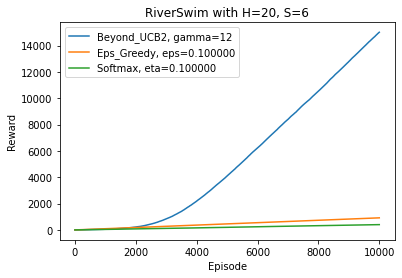

In [11]:
plt.plot(R1,label='Beyond_UCB2, gamma='+str(int(gamma)))
plt.plot(R2,label='Eps_Greedy, eps=%f' % epsilon)
plt.plot(R3,label='Softmax, eta=%f'% eta)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("RiverSwim with H=20, S=6")
plt.savefig("beyonducb_"+str(int(gamma))+".pdf")
plt.show()

In [12]:
K = 10000
runs = 10
delta = 1/K
eta = 0.1
epsilon = 0.1
n =  10
env = Deep_Sea(num_steps = n)
gamma = np.sqrt(K*env.epLen*env.nAction/(env.nAction*env.nState*env.epLen*np.log(2/delta)))

r1 = np.zeros((runs,K)) # Beyond_Q
r2 = np.zeros((runs,K)) # E-Greedy
r3 = np.zeros((runs,K)) # Softmax

for r in tqdm(range(runs)):
    agent1 = Beyond_Q(env,K,gamma)
    r1[r,:] = agent1.run()

    agent2 = Eps_Q(env,K,epsilon)
    r2[r,:] = agent2.run()

    agent3 = Softmax_Q(env,K,eta)
    r3[r,:] = agent3.run()

R1 = np.mean(r1,axis=0)
R2 = np.mean(r2,axis=0)
R3 = np.mean(r3,axis=0)


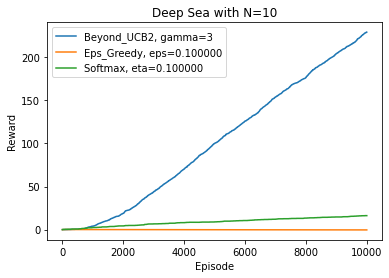

In [13]:
plt.plot(R1,label='Beyond_UCB2, gamma='+str(int(gamma)))
plt.plot(R2,label='Eps_Greedy, eps=%f' % epsilon)
plt.plot(R3,label='Softmax, eta=%f'% eta)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Deep Sea with N=%d" %  n)
plt.savefig("beyonducb_"+str(int(gamma))+".pdf")
plt.show()

In [14]:
K = 100000
runs = 10
delta = 1/K
eta = 0.1
epsilon = 0.1
n =  15
env = Deep_Sea(num_steps = n)
#gamma = np.sqrt(K*env.epLen*env.nAction/(env.nAction*env.nState*env.epLen*np.log(2/delta)))
gamma = 10
r1 = np.zeros((runs,K)) # Beyond_Q

for r in tqdm(range(runs)):
    agent1 = Beyond_Q(env,K,gamma)
    r1[r,:] = agent1.run()

In [15]:
r2 = np.zeros((runs,K)) # E-Greedy
for r in tqdm(range(runs)):
    agent2 = Eps_Q(env,K,epsilon)
    r2[r,:] = agent2.run()



In [16]:
r3 = np.zeros((runs,K)) # Softmax
for r in tqdm(range(runs)):
    agent3 = Softmax_Q(env,K,eta)
    r3[r,:] = agent3.run()

R1 = np.mean(r1,axis=0)
R2 = np.mean(r2,axis=0)
R3 = np.mean(r3,axis=0)


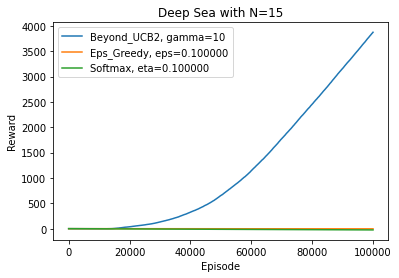

In [17]:
plt.plot(R1,label='Beyond_UCB2, gamma='+str(int(gamma)))
plt.plot(R2,label='Eps_Greedy, eps=%f' % epsilon)
plt.plot(R3,label='Softmax, eta=%f'% eta)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Deep Sea with N=%d" %  n)
plt.savefig("beyonducb_"+str(int(gamma))+".pdf")
plt.show()